# Problema da Caixeiro Viajante
## Implementação Serial

In [5]:
import time as t
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
%%writefile caixeiro_mpi.py
# Importação das bibliotecas
import random
import sys
import math
#Importando MPI
from mpi4py import MPI

comm = MPI.COMM_WORLD

#Definindo o rank e o size
rank = comm.rank
size = comm.size
status = MPI.Status()

# CONSTANTES DEFINIDAS NA EXECUÇÃO
QTD_CIDADES   = int(sys.argv[1])
DIST_MAX      = int(sys.argv[2])
DIST_MIN      = int(sys.argv[3])
IMPRESSAO     = sys.argv[4]

qtd_processos = size
if qtd_processos > QTD_CIDADES:
    qtd_processos = QTD_CIDADES

# Cálculo de Custos
def calcular_custos(lista, matriz_custo):
    custo = 0
    for pos_dest in range(1,len(lista)):
        if lista[pos_dest] > lista[pos_dest-1]:
            custo += matriz_custo[lista[pos_dest-1]][lista[pos_dest]]
        else:
            custo += matriz_custo[lista[pos_dest]][lista[pos_dest-1]]
    return custo

def permutacoes(lista):
    if len(lista) == 0:
        return[[]]
    combinacoes = []
    for i in range(len(lista)):
        valor_atual = lista[i]
        lista_restante = lista[:i]+lista[i+1:]
        lista_permutacoes = permutacoes(lista_restante)
        for permutacao in lista_permutacoes:
            combinacoes.append([valor_atual]+permutacao)
    return combinacoes

def gerar_listas_e_enviar_pros_processos(lista_cidades, matriz_custo):
    matriz_informacoes = [x for x in range(1, qtd_processos)]
    for x in lista_cidades:
        process = x
        cidade_faltante = x

        lista_temp = lista_cidades.copy()
        lista_temp.remove(x)

        informacoes = (lista_temp, cidade_faltante)
        if process >= qtd_processos:
            process = process % qtd_processos + 1
            matriz_informacoes[process-1].append(informacoes)
        else:
            matriz_informacoes[process-1] = [informacoes]
    for i in range(0, qtd_processos-1):
        comm.send((matriz_custo, matriz_informacoes[i]), dest=i+1)



def gerar_combinacao_inicial(qtd_cidades):
    combinacao = [x for x in range(1, qtd_cidades)]
    return combinacao

# Função geradora do custo (Matriz de Custo)
def gera_matriz_custo(qtd_cidades, dist_max, dist_min):
    random.seed(12)
    matriz_custo = []
    for cid_origem in range(qtd_cidades):
        matriz_custo.append([])
        for cid_destino in range(qtd_cidades):
            if cid_origem < cid_destino:
                matriz_custo[cid_origem].append(random.randint(dist_max, dist_min))
            else:
                matriz_custo[cid_origem].append(0)

    print('** CIDADE **')
    for cid_origem in range(QTD_CIDADES):
        print(matriz_custo[cid_origem])
    return matriz_custo

def receber_combinacoes():
    melhores_combinacao_final = []
    for i in range(1, qtd_processos):
        melhores_combinacoes  = comm.recv(source=i)
        for combinacao in melhores_combinacoes:
            melhor_combinacao = combinacao
            if melhores_combinacao_final == []:
                melhores_combinacao_final = [melhor_combinacao]
            elif melhor_combinacao[1] < melhores_combinacao_final[0][1]:
                melhores_combinacao_final = [melhor_combinacao]
            elif melhor_combinacao[1] == melhores_combinacao_final[0][1]:
                melhores_combinacao_final.append(melhor_combinacao)
    return melhores_combinacao_final

def melhores_combinacoes(informacoes):
    melhores_combinacoes = []

    for info in informacoes:
        lista_cidades = info[0]
        cidade_faltante = info[1]
        combinacoes = permutacoes(lista_cidades)
        for combinacao in combinacoes:
            combinacao.insert(0, cidade_faltante)
            combinacao.insert(0,0)
            combinacao.append(0)
            custo = calcular_custos(combinacao, matriz_custo)
            if melhores_combinacoes == []:
                melhores_combinacoes = [[combinacao, custo]]
            elif custo < melhores_combinacoes[0][1]:
                melhores_combinacoes = [[combinacao, custo]]
            elif custo == melhores_combinacoes[0][1]:
                melhores_combinacoes.append([combinacao, custo])

    return melhores_combinacoes


if rank == 0:
    matriz_custo = gera_matriz_custo(QTD_CIDADES, DIST_MAX, DIST_MIN)
    combinacao_inicial = gerar_combinacao_inicial(QTD_CIDADES)
    gerar_listas_e_enviar_pros_processos(combinacao_inicial, matriz_custo)
    melhores_combinacoes = receber_combinacoes()
    print('Melhores Combinacoes:', melhores_combinacoes)
else:
    if rank < qtd_processos:
        matriz_custo, informacoes = comm.recv(source=0)
        melhores_combinacoes = melhores_combinacoes(informacoes)
        comm.send(melhores_combinacoes, dest=0)


Writing caixeiro_mpi.py


## Teste do código serial com passagem de parâmetros

In [6]:
# Teste QTD_CIDADES, DIST_MIN, DIST_MAX, PRINT
!mpiexec -n 6 python caixeiro_mpi.py 10 2 9 'True'

** CIDADE **
[0, 9, 6, 7, 4, 8, 2, 7, 9, 6]
[0, 0, 9, 5, 2, 4, 9, 7, 4, 7]
[0, 0, 0, 5, 2, 5, 3, 7, 8, 3]
[0, 0, 0, 0, 2, 2, 5, 3, 8, 9]
[0, 0, 0, 0, 0, 3, 8, 4, 7, 4]
[0, 0, 0, 0, 0, 0, 2, 4, 3, 8]
[0, 0, 0, 0, 0, 0, 0, 8, 9, 9]
[0, 0, 0, 0, 0, 0, 0, 0, 8, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Melhores Combinacoes: [[[0, 6, 2, 9, 7, 3, 5, 8, 1, 4, 0], 28], [[0, 6, 5, 3, 7, 9, 8, 1, 4, 2, 0], 28], [[0, 2, 4, 1, 8, 9, 7, 3, 5, 6, 0], 28], [[0, 4, 1, 8, 5, 3, 7, 9, 2, 6, 0], 28]]


## Definição de constantes

In [18]:
QTD_CIDADES   = 11
DIST_MIN      = 2
DIST_MAX      = 9

## Fazendo testes de complexidade 
### <font color='Red'>(Execução Demorada!)</font>

In [20]:
# Teste de estresse
tempo_exec=[]
tempo_teorico=[]
for i in range(5, QTD_CIDADES+1):
    tempo_atual = t.time()
    # Teste QTD_CIDADES, DIST_MIN, DIST_MAX
    string = 'mpiexec -n 6 python caixeiro_mpi.py '+str(QTD_CIDADES)+' '+str(DIST_MIN)+' '+\
                str(DIST_MAX)+' \'False\' > NUL' #Jogando a saida para null para não poluir o terminal
    !$string
    tempo_final = t.time()
    tempo_final -= tempo_atual
    tempo_exec.append((i,tempo_final))
    #Comparando os resultados com os valores de f(i) = 2*f(i-1)
    tempo_teorico.append((i+1, tempo_final*DIST_MAX))
print(tempo_exec)
print(tempo_teorico)

^C
[(5, 3.9794209003448486), (6, 4.029872179031372), (7, 3.9218637943267822), (8, 3.9856979846954346), (9, 1.7830123901367188), (10, 5.589579343795776), (11, 4.266306161880493)]
[(6, 35.81478810310364), (7, 36.26884961128235), (8, 35.29677414894104), (9, 35.87128186225891), (10, 16.04711151123047), (11, 50.30621409416199), (12, 38.39675545692444)]


## Gráfico de complexidade X Tamanho da List

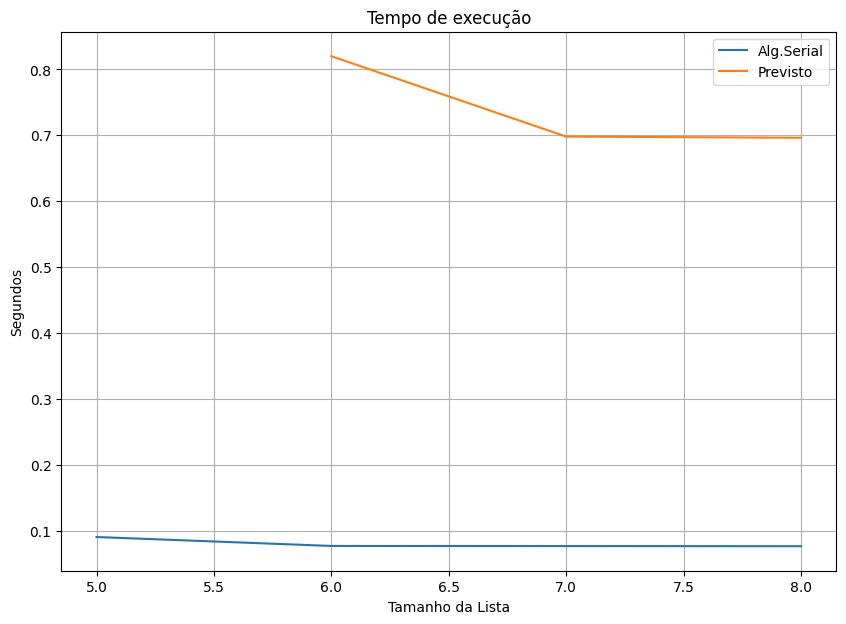

In [6]:
plt.figure(figsize=(10,7))
plt.plot([tempo_exec[i][0] for i in range(len(tempo_exec))], [tempo_exec[i][1] for i in range(len(tempo_exec))], label='Alg.Serial')
plt.plot([tempo_teorico[i][0] for i in range(len(tempo_teorico)-1)], [tempo_teorico[i][1] for i in range(len(tempo_teorico)-1)], label='Previsto')
plt.title('Tempo de execução')
plt.xlabel('Tamanho da Lista')
plt.ylabel('Segundos')
plt.legend()
plt.grid()
plt.show()

## Fazendo testes com constantes definidas (1000 testes) 
### <font color='Red'>(Execução Demorada!)</font>
### Novas constantes para os testes

In [6]:
QTD_CIDADES   = 11
DIST_MIN      = 2
DIST_MAX      = 9

In [7]:
TAM_POP   = 1000  # Tamanho da População

In [8]:
# Teste de estresse 2
tempo_exec2=[]
for i in range(TAM_POP):
    tempo_atual = t.time()
    # Teste QTD_CIDADES, DIST_MIN, DIST_MAX
    string = 'mpiexec -n 6 python caixeiro_mpi.py '+str(QTD_CIDADES)+' '+str(DIST_MIN)+' '+str(DIST_MAX)+' '+'\'False\''+' > NUL' #Jogando a saida para null para não poluir o terminal
    !$string
    tempo_final = t.time()
    tempo_final -= tempo_atual
    tempo_exec2.append((i,tempo_final))
    print('Execução: %d - Tempo: %.4f seg.' %(i, tempo_final))
#print(tempo_exec2)

Execução: 0 - Tempo: 4.0537 seg.
Execução: 1 - Tempo: 3.9789 seg.
Execução: 2 - Tempo: 3.9863 seg.
Execução: 3 - Tempo: 3.9516 seg.
Execução: 4 - Tempo: 3.7520 seg.
Execução: 5 - Tempo: 3.9258 seg.
Execução: 6 - Tempo: 3.9043 seg.
Execução: 7 - Tempo: 3.8589 seg.
Execução: 8 - Tempo: 3.9515 seg.
Execução: 9 - Tempo: 3.9108 seg.
Execução: 10 - Tempo: 3.9710 seg.
Execução: 11 - Tempo: 3.8941 seg.
Execução: 12 - Tempo: 3.8339 seg.
Execução: 13 - Tempo: 4.0547 seg.
Execução: 14 - Tempo: 4.0411 seg.
Execução: 15 - Tempo: 4.0186 seg.
Execução: 16 - Tempo: 4.0379 seg.
Execução: 17 - Tempo: 3.9749 seg.
Execução: 18 - Tempo: 3.9495 seg.
Execução: 19 - Tempo: 3.9915 seg.
Execução: 20 - Tempo: 4.1576 seg.
Execução: 21 - Tempo: 4.0105 seg.
Execução: 22 - Tempo: 4.0112 seg.
Execução: 23 - Tempo: 3.8221 seg.
Execução: 24 - Tempo: 3.9982 seg.
Execução: 25 - Tempo: 4.0678 seg.
Execução: 26 - Tempo: 4.0481 seg.
Execução: 27 - Tempo: 4.0899 seg.
Execução: 28 - Tempo: 3.9774 seg.
Execução: 29 - Tempo: 3.

## Transfomando dados para 'numpy' para uso estatístico
<H3><font color='Red'>Só rodar se a célula anterior for executada</font></H3>

In [9]:
tempo_exec2 = np.array(tempo_exec2)
np.savetxt('dataset_multi_core.txt', tempo_exec2, fmt='%f')
#tempo_exec2

# Análise Estatística

## Leitura do Dataset

In [10]:
# Lendo o dataset armazenado
tempo_exec2 = np.loadtxt('dataset_multi_core.txt', dtype = float)

## Gráfico de disperção no tempo de execução

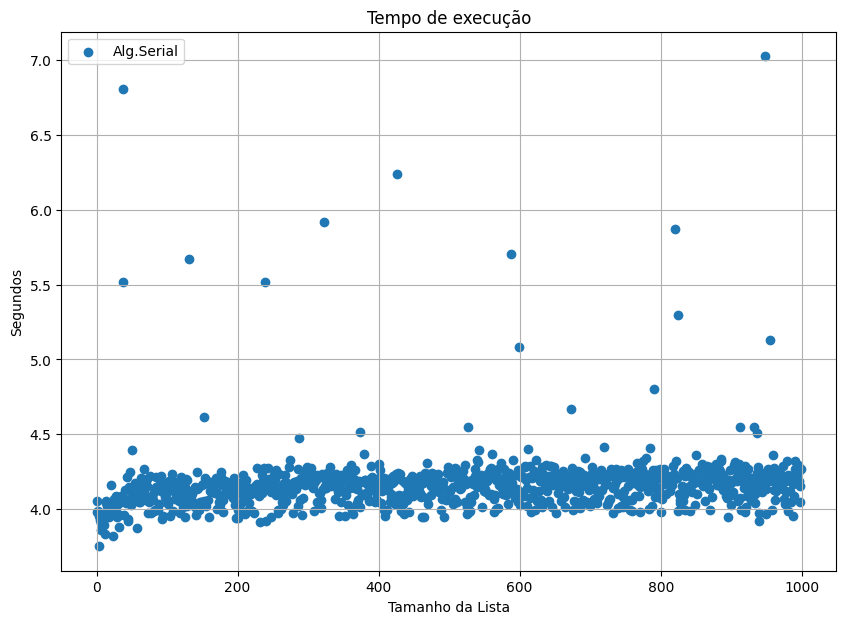

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(tempo_exec2[:,0], tempo_exec2[:,1], label='Alg.Serial')
plt.title('Tempo de execução')
plt.xlabel('Tamanho da Lista')
plt.ylabel('Segundos')
plt.legend()
plt.grid()
plt.show()

## Cálculo de valores centrais:
### (Média, Mediana, Moda)

In [12]:
# Média
tempo_exec2_media = tempo_exec2[:,1].mean()
print('Tempo médio de execução %.4f' %tempo_exec2_media)

Tempo médio de execução 4.1659


In [13]:
# Desvio Padrão
tempo_exec2_std = tempo_exec2[:,1].std()
print('Desvio padrão %.4f' %tempo_exec2_std)

Desvio padrão 0.2193


In [14]:
# Médiana
tempo_exec2_mediana = np.median(tempo_exec2[:,1])
print('Tempo mediano de execuçao %.4f' %tempo_exec2_mediana)

Tempo mediano de execuçao 4.1562


## Análise Frequências

Não é possivel calcular a moda de uma população de valores numéricos contínuos. Neste caso podemos aplicar a **Regra de Sturges** para calcular a frequência da distribuição da amostra.
$$k = 1 + \frac {10}{3}\log_{10}n$$

In [15]:
# Cálculo do intervalo de freqûencia: n = Tamanho da Amostra
n = tempo_exec2.shape[0]
k = 1 + (10/3)*np.log10(n)
k = int(k.round(0))
print(f'Tamanho da Amostra: {k}')

Tamanho da Amostra: 11


In [16]:
# Coletando a frequência
tempo_exec2_freq = np.histogram(tempo_exec2[:,1], bins= k)
print(tempo_exec2_freq)

(array([180, 790,  16,   2,   2,   3,   2,   2,   1,   0,   2], dtype=int64), array([3.752002  , 4.04955727, 4.34711255, 4.64466782, 4.94222309,
       5.23977836, 5.53733364, 5.83488891, 6.13244418, 6.42999945,
       6.72755473, 7.02511   ]))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


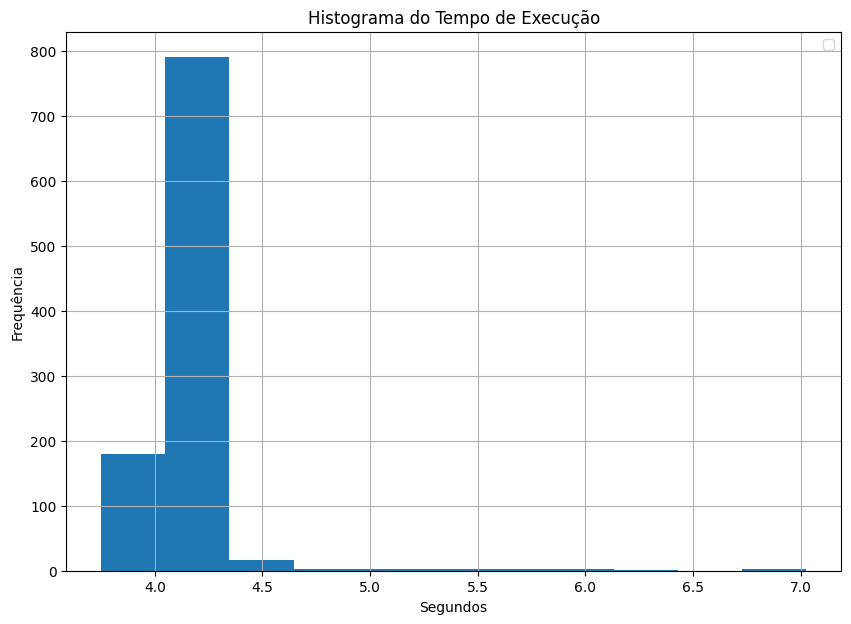

In [17]:
plt.figure(figsize=(10,7))
plt.hist(tempo_exec2[:,1], bins = k)
plt.title('Histograma do Tempo de Execução')
plt.ylabel('Frequência')
plt.xlabel('Segundos')
plt.legend()
plt.grid()
plt.show()

### **Verificando a possbilidade de dados OUTLIERS**
**Medidas Separatrizes**: Quartis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


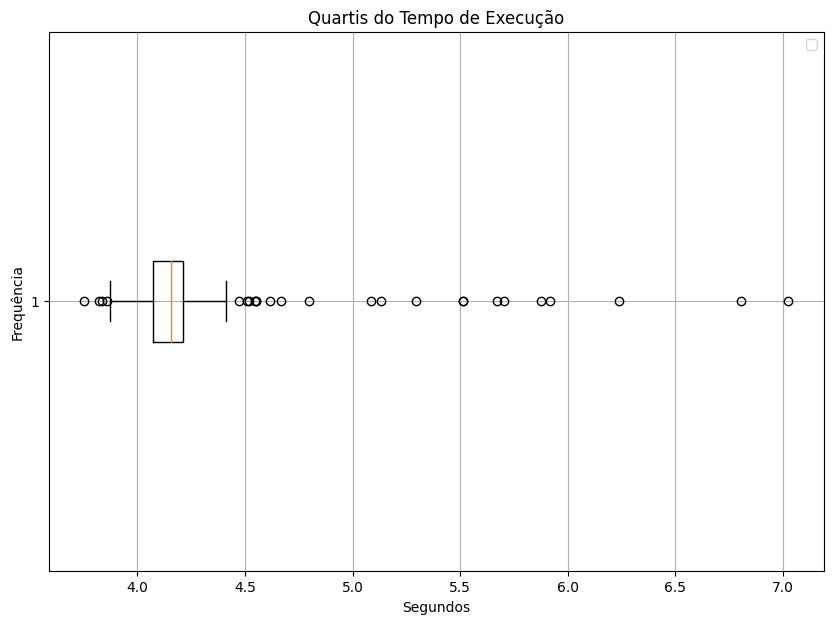

In [18]:
# Gráfico BoxPlot
plt.figure(figsize=(10,7))
plt.boxplot(tempo_exec2[:,1], vert = False)
plt.title('Quartis do Tempo de Execução')
plt.ylabel('Frequência')
plt.xlabel('Segundos')
plt.legend()
plt.grid()
plt.show()

### **Removendo dados "extremos" - Outliers**
#### <font color='Red'> Ajustar os valores antes de executar </font>

In [19]:
# Remover valores da lista
int_sup = tempo_exec2_media + (2 * tempo_exec2_std)
int_inf = tempo_exec2_media - (2 * tempo_exec2_std)
print(f'Nº de registros originais: {tempo_exec2.shape[0]}')
registros = []
for i in range(tempo_exec2.shape[0]):
        if int_inf > tempo_exec2[i, 1] or tempo_exec2[i, 1] > int_sup:
            registros.append(i)
print(f'Qtd. de registros removidos: {len(registros)}')
print(f'Registros removidos: {registros}')
tempo_exec2 = np.delete(tempo_exec2, registros, 0)
print(f'Nº de registros corrigidos: {tempo_exec2.shape[0]}')
print(tempo_exec2[0:15])

Nº de registros originais: 1000
Qtd. de registros removidos: 15
Registros removidos: [37, 38, 131, 152, 239, 323, 426, 588, 599, 673, 791, 820, 824, 948, 955]
Nº de registros corrigidos: 985
[[ 0.        4.053715]
 [ 1.        3.978933]
 [ 2.        3.986342]
 [ 3.        3.951649]
 [ 4.        3.752002]
 [ 5.        3.925791]
 [ 6.        3.904343]
 [ 7.        3.858905]
 [ 8.        3.951485]
 [ 9.        3.910772]
 [10.        3.970983]
 [11.        3.894115]
 [12.        3.833888]
 [13.        4.054711]
 [14.        4.041118]]


### Salvando os registros corrigidos

In [20]:
np.savetxt('dataset_multi_core_corrigido.txt', tempo_exec2, fmt='%f')

In [21]:
# Média
tempo_exec2_media = tempo_exec2[:,1].mean()
print('Tempo médio de execução %f' %tempo_exec2_media)

Tempo médio de execução 4.144185


In [22]:
# Desvio Padrão
tempo_exec2_std = tempo_exec2[:,1].std()
print('Desvio padrão %.4f' %tempo_exec2_std)

Desvio padrão 0.1010


In [23]:
# Médiana
tempo_exec2_mediana = np.median(tempo_exec2[:,1])
print('Tempo mediano de execuçao %.4f' %tempo_exec2_mediana)

Tempo mediano de execuçao 4.1549


## Estatística - DISTRIBUIÇÕES DE PROBABILIDADE

### Distribuição Normal

#### Amostra (Média da População)

In [24]:
# Parâmetros para uma media de amostragens
tam_amost = 50
qtd_amost = 200

In [25]:
# Obtendo a media de amostragens
amostra = []
for i in range(qtd_amost):
    amostra.append(np.random.choice(tempo_exec2[:,1], tam_amost).mean())
amostra = np.array(amostra)

In [26]:
# Valores Centrais da amostragem
amostra_media   = amostra.mean()
amostra_std     = amostra.std()
amostra_mediana = np.median(amostra)
print('** Valores Centrais da Amostra **')
print('Média da amostra:       %.4f' %amostra_media)
print('Desv.Padrão da amostra: %.4f' %amostra_std)
print('Mediana da amostra:     %.4f' %amostra_mediana)

** Valores Centrais da Amostra **
Média da amostra:       4.1449
Desv.Padrão da amostra: 0.0159
Mediana da amostra:     4.1447


In [27]:
# Desvio Padrão de inferência calculado
round(tempo_exec2_std / np.sqrt(tam_amost),4)

0.0143

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


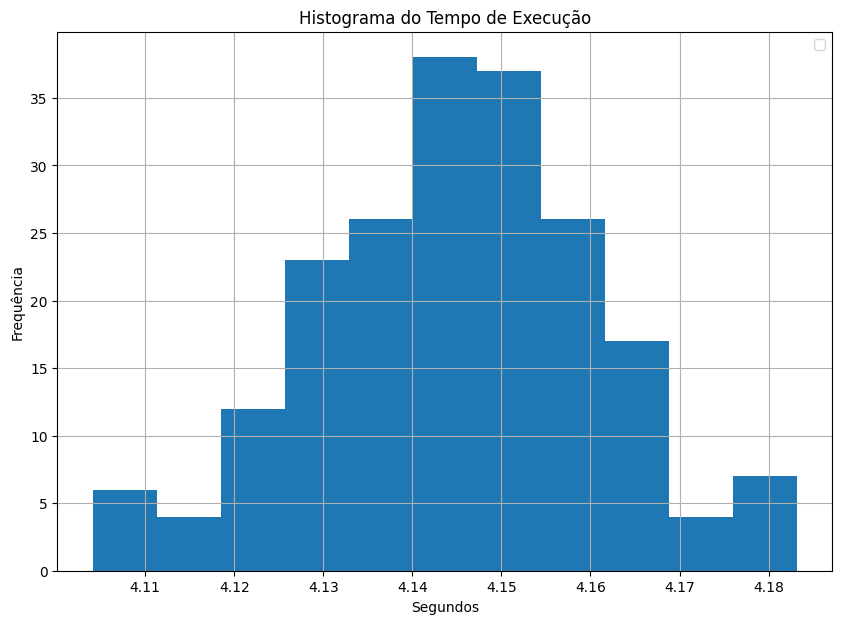

In [28]:
# Visualizando a amostra:
plt.figure(figsize=(10,7))
plt.hist(amostra, bins = k)
plt.title('Histograma do Tempo de Execução')
plt.ylabel('Frequência')
plt.xlabel('Segundos')
plt.legend()
plt.grid()
plt.show()

In [29]:
# Considerando a confiança de 99%
intervalo = norm.interval(alpha = 0.99, loc = amostra_media, scale = amostra_std)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_13920\3257524375.py:2: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  intervalo = norm.interval(alpha = 0.99, loc = amostra_media, scale = amostra_std)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


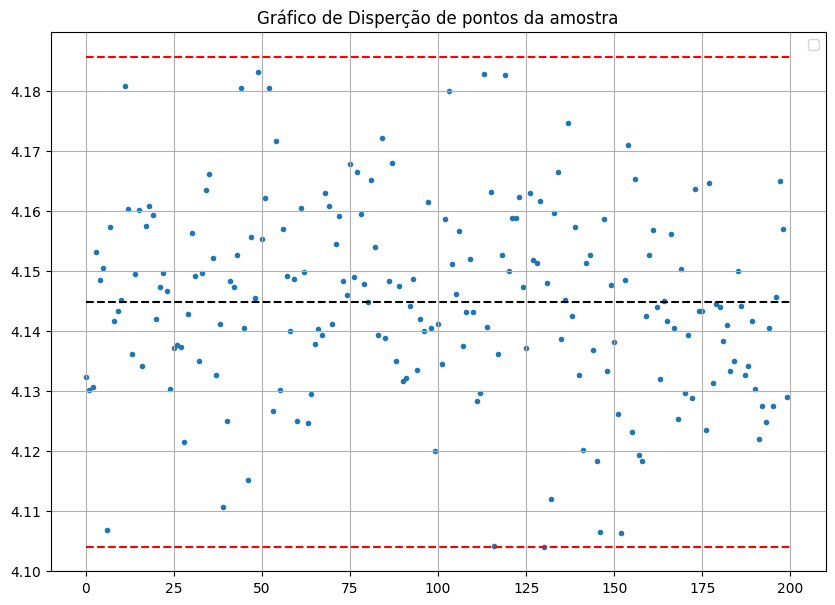

In [30]:
# Visualizando a disperção de Pontos da Amostra
plt.figure(figsize=(10,7))
plt.scatter([i for i in range(qtd_amost)], amostra, marker='.')
plt.hlines(y=intervalo[0], xmin=0, xmax=qtd_amost, color='red', linestyles='dashed')
plt.hlines(y=intervalo[1], xmin=0, xmax=qtd_amost, color='red', linestyles='dashed')
plt.hlines(y=amostra_media, xmin=0, xmax=qtd_amost, color='black', linestyles='dashed')
plt.title('Gráfico de Disperção de pontos da amostra')
plt.legend()
plt.grid()
plt.show()